In [51]:
%pip uninstall -y numpy scikit-video opencv-python matplotlib
%pip install -r requirements.txt

Found existing installation: numpy 2.2.0
Uninstalling numpy-2.2.0:
  Successfully uninstalled numpy-2.2.0
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Note: you may need to restart the kernel to use updated packages.


In [52]:
import skvideo.io
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import json
import cv2.legacy
import imageio
from IPython.display import Image, display

In [53]:
# hardcode the video path
PATH = '../../../data/'
OUTPUT_PATH = '../../outputs/'
video_path = os.path.join(PATH, 'video.mov')

In [54]:
def show_image(im, title=None):
    plt.figure()
    plt.imshow(im)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()

def show_image_with_points(image, points, title=None, s=5):
    plt.figure()
    plt.imshow(image)
    plt.scatter(points[:, 0], points[:, 1], c='r', marker='.', s=s)
    if title is not None:
        plt.title(title)
    plt.show()

def show_image_with_numbers(image, points, title=None, s=5):
    plt.figure()
    plt.imshow(image)
    plt.scatter(points[:, 0], points[:, 1], c='r', marker='.', s=s)
    # Add numbers next to each point
    for i, (x, y) in enumerate(points):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points')
    if title is not None:
        plt.title(title)
    plt.show()

def show_collection_of_images(images, titles=None, points=None, show_numbers=False, s=5):
    plt.figure(figsize=(15, 5))  # Adjust figure size for better layout
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image)
        plt.axis('off')
        if points is not None and i < len(points):
            plt.scatter(points[i][:, 0], points[i][:, 1], c='r', marker='.', s=s)
            if show_numbers:
                for j, (x, y) in enumerate(points[i]):
                    plt.annotate(str(j), (x, y), xytext=(5, 5), textcoords='offset points')
        if titles is not None:
            plt.title(titles[i], wrap=True)  # Enable text wrapping
    plt.tight_layout()  # Adjust subplot layout
    plt.show()

def make_video(frames, output_path):
    imageio.mimsave(output_path, frames, fps=30, format='GIF-PIL')

## Writing initial anchor points

Total frames extracted: 136


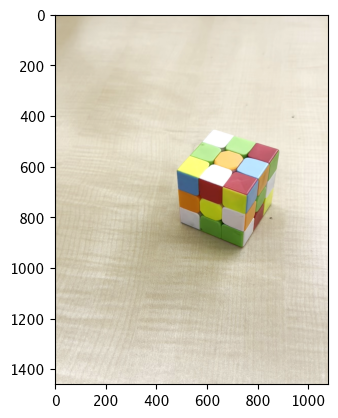

True

In [55]:

cap = cv2.VideoCapture(video_path)
frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)

cap.release()
first_frame = frames[0]
print(f"Total frames extracted: {len(frames)}")
# save the first frame
# show the first frame
plt.imshow(first_frame)
plt.show()
cv2.imwrite(os.path.join(OUTPUT_PATH, 'first_frame.png'), first_frame)


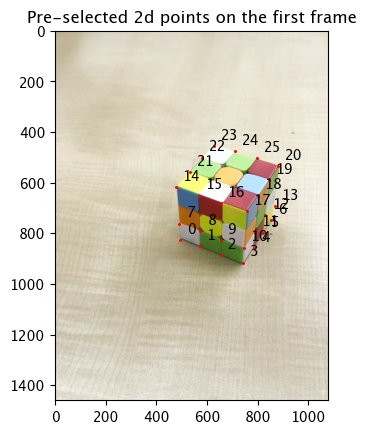

In [56]:
# reading in points from json
with open('correspondences1.json', 'r') as f:
    data = json.load(f)
    initial_points_2D = data['im1Points']
    initial_points_2D = np.array(initial_points_2D)
    _ = data['im2Points']
# display the points on the first frame
show_image_with_numbers(first_frame, initial_points_2D, title='Pre-selected 2d points on the first frame')

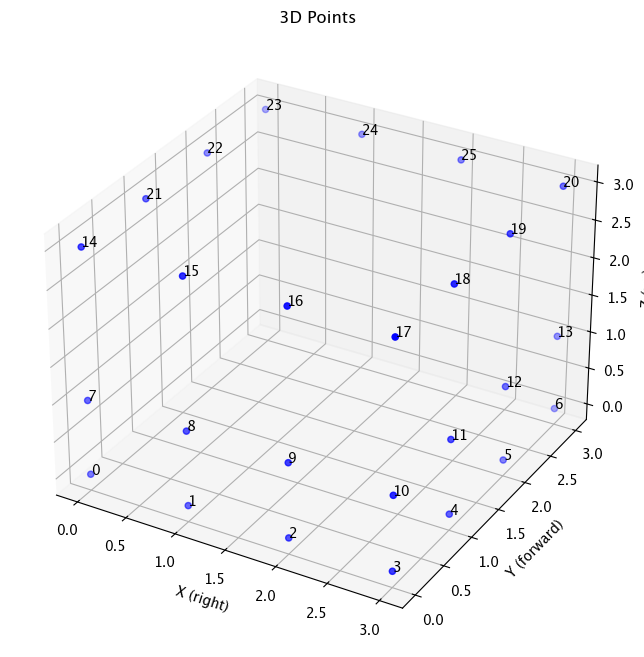

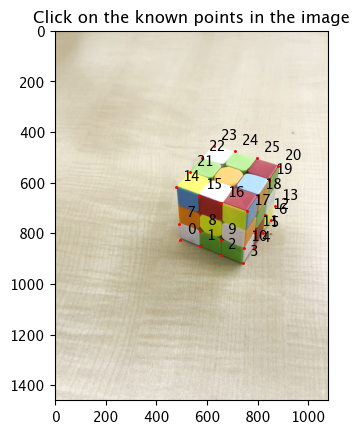

In [57]:
# define the 3D points
known_points_3D = np.array([ # (right, forward, up)
    [0,0,0], [1,0,0], [2,0,0], [3,0,0],
    [3,1,0], [3,2,0], [3,3,0], # bottom layer

    [0,0,1], [1,0,1], [2,0,1], [3,0,1],
    [3,1,1], [3,2,1], [3,3,1], # middle layer

    [0,0,3], [1,0,3], [2,0,3], [3,0,3],
    [3,1,3], [3,2,3], [3,3,3], # top layer (front)

    [0, 1, 3], [0, 2, 3], [0, 3, 3], # top layer (left)
    [1, 3, 3], [2, 3, 3]
], dtype=float)

# display the 3D points
def plot_3d_points(points_3d):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the points
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='b', marker='o')
    
    # Add point labels
    for i, (x, y, z) in enumerate(points_3d):
        ax.text(x, y, z, str(i))
    
    # Set labels and title
    ax.set_xlabel('X (right)')
    ax.set_ylabel('Y (forward)') 
    ax.set_zlabel('Z (up)')
    ax.set_title('3D Points')
    
    plt.show()

# Display the 3D points
plot_3d_points(known_points_3D)

show_image_with_numbers(first_frame, initial_points_2D, title='Click on the known points in the image')

In [58]:
# remove problematic points
def remove_points_by_index(indices_to_remove):
    """
    Remove points at specified indices from both initial_points_2D and known_points_3D
    
    Parameters
    ----------
    indices_to_remove : list of int
        Indices of points to remove
        
    Returns
    -------
    ndarray
        Remaining 2D points after removal
    """
    global initial_points_2D, known_points_3D
    
    # Create boolean mask for points to keep
    mask = np.ones(len(initial_points_2D), dtype=bool)
    mask[indices_to_remove] = False
    
    # Apply mask to both point arrays
    initial_points_2D = initial_points_2D[mask]
    known_points_3D = known_points_3D[mask]
    
    return



problematic_indices = [13, 23, 24, 25]
remove_points_by_index(problematic_indices)





# Tracking points between frames

In [59]:
def track_points(initial_points_2D, frames, patch_size=8):
    """
    Track points through a sequence of frames using MedianFlow tracker
    
    Parameters
    ----------
    initial_points_2D : ndarray of shape (N, 2)
        Initial 2D coordinates of points to track
    frames : list of ndarrays
        Sequence of frames to track points through
    patch_size : int, optional
        Size of patch to track around each point (default 8)
        
    Returns
    -------
    tracked_points : list of ndarrays
        List of tracked point coordinates for each frame
    """
    trackers = []
    first_frame = frames[0]

    # Initialize a tracker for each point
    for (x, y) in initial_points_2D:
        # The bbox uses top-left coords followed by width and height
        start_x = x - patch_size/2
        start_y = y - patch_size/2
        bbox = (start_x, start_y, patch_size, patch_size)

        # Depending on your OpenCV version, the tracker might be in cv2.legacy
        tracker = cv2.legacy.TrackerMedianFlow_create()
        tracker.init(first_frame, bbox)
        trackers.append(tracker)

    # Now track through the rest of the frames
    tracked_points = [initial_points_2D]
    for i in range(1, len(frames)):
        frame = frames[i]
        new_points = []
        for tracker in trackers:
            success, new_bbox = tracker.update(frame)
            if success:
                # Convert bbox center back to a point
                (x, y, w, h) = new_bbox
                cx = x + w/2
                cy = y + h/2
                new_points.append([cx, cy])
            else:
                # If tracking fails, append None or skip
                new_points.append([np.nan, np.nan])

        tracked_points.append(np.array(new_points))

    return tracked_points

tracked_points = track_points(initial_points_2D, frames)

136


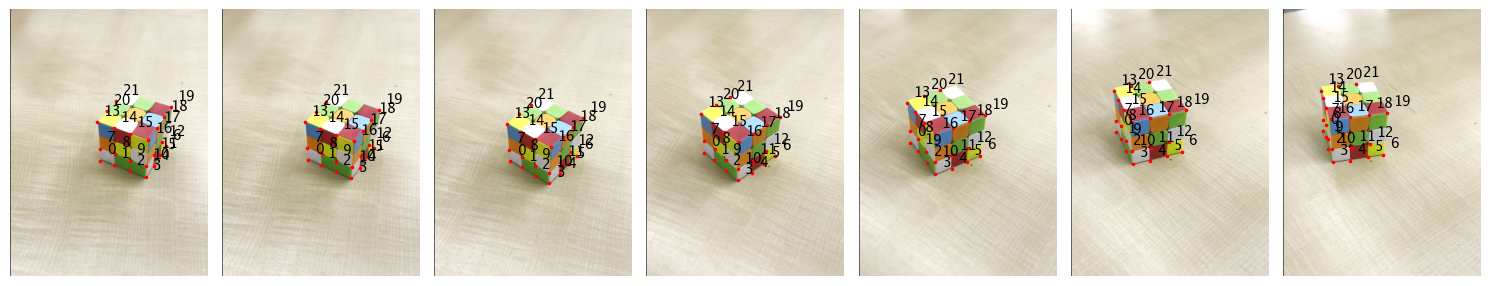

In [60]:
skip = 20
example_frames = frames[::skip]

example_tracked_points = tracked_points[::skip]
print(len(tracked_points))
show_collection_of_images(example_frames, titles=None, points=example_tracked_points, show_numbers=True, s=10)

# Calibrating the camera

In [61]:
def estimate_camera_matrix(pts_3d, pts_2d):
    """
    Estimate the camera projection matrix P given corresponding 3D and 2D points.
    
    Parameters
    ----------
    pts_3d : ndarray of shape (N, 3)
        3D coordinates of points in world space.
    pts_2d : ndarray of shape (N, 2)
        2D coordinates of the corresponding points in the image plane.

    Returns
    -------
    P : ndarray of shape (3, 4)
        The 3x4 camera projection matrix.
    """
    # Convert to homogeneous coordinates
    num_points = pts_3d.shape[0]
    pts_3d_h = np.hstack([pts_3d, np.ones((num_points, 1))])
    pts_2d_h = np.hstack([pts_2d, np.ones((num_points, 1))])

    # Construct the A matrix from the DLT formulation
    # For each correspondence (X, Y, Z) -> (x, y)
    # we get two equations:
    # x*P3X - P1X = 0 and y*P3X - P2X = 0
    # where P1, P2, P3 are the rows of P.
    A = []
    for i in range(num_points):
        X, Y, Z, _ = pts_3d_h[i]
        x, y, _ = pts_2d_h[i]

        # Row for x
        A.append([X, Y, Z, 1, 0, 0, 0, 0, -x*X, -x*Y, -x*Z, -x])
        # Row for y
        A.append([0, 0, 0, 0, X, Y, Z, 1, -y*X, -y*Y, -y*Z, -y])

    A = np.array(A)
    
    # Solve A p = 0 using SVD
    # p is the vectorized form of P (12 parameters)
    U, S, Vt = np.linalg.svd(A)
    p = Vt[-1]  # The solution is the last row of V

    # Reshape p into P
    P = p.reshape(3, 4)

    # Normalize so that bottom-right element is 1 if desired
    if P[2,3] != 0:
        P = P / P[2,3]

    return P

# Example usage:
# pts_3d = np.array([[0,0,0],
#                    [1,0,0],
#                    [1,1,0],
#                    [0,1,0],
#                    [0,0,1],
#                    [1,0,1],
#                    [1,1,1],
#                    [0,1,1]])
# pts_2d = np.array([[100,200],
#                    [200,200],
#                    [200,300],
#                    [100,300],
#                    [110,210],
#                    [210,210],
#                    [210,310],
#                    [110,310]])
#
P = estimate_camera_matrix(known_points_3D, initial_points_2D)
print("Estimated Camera Projection Matrix:\n", P)


Estimated Camera Projection Matrix:
 [[ 7.23139479e+01  6.18732884e+01 -2.44630928e+01  4.95478281e+02]
 [ 1.93039571e+01 -3.42906846e+01 -9.34844262e+01  8.24873971e+02]
 [-1.30321346e-02  2.94118560e-02 -3.87989972e-02  1.00000000e+00]]


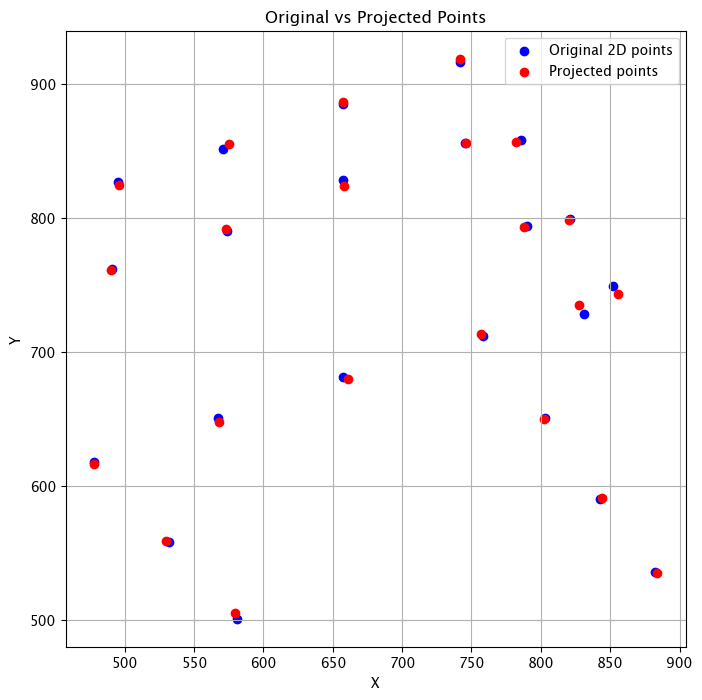

In [62]:
def project_points(points_3d, projection_matrix):
    """
    Project 3D points using a camera projection matrix.
    
    Args:
        points_3d: Array of 3D points to project
        projection_matrix: 3x4 camera projection matrix
        
    Returns:
        Array of projected 2D points
    """
    projected_points = []
    for point_3d in points_3d:
        # Convert to homogeneous coordinates by adding 1
        point_3d_h = np.append(point_3d, 1)
        
        # Apply projection matrix
        point_2d_h = projection_matrix @ point_3d_h
        
        # Convert from homogeneous to Euclidean coordinates
        point_2d = point_2d_h[:2] / point_2d_h[2]
        projected_points.append(point_2d)

    return np.array(projected_points)

# Project the points using the estimated camera matrix
projected_points = project_points(known_points_3D, P)

# Plot the projected points vs the original 2D points
plt.figure(figsize=(8, 8))
plt.scatter(initial_points_2D[:, 0], initial_points_2D[:, 1], c='blue', label='Original 2D points')
plt.scatter(projected_points[:, 0], projected_points[:, 1], c='red', label='Projected points')
plt.legend()
plt.title('Original vs Projected Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


# adding the new object's points

In [63]:
# cube's points
# lets make it a 3x3x3 cube sitting on top of the cube
cube_origin = np.array([0,0,3])
def get_cube_corners(origin, size=3):
    """
    Generate 8 corners of a cube in the correct order for drawing:
    Bottom face: [0,1,2,3] (counter-clockwise)
    Top face: [4,5,6,7] (counter-clockwise)
    """
    corners = []
    # Bottom face (counter-clockwise)
    corners.append(origin + np.array([0, 0, 0]))  # front-left
    corners.append(origin + np.array([size, 0, 0]))  # front-right
    corners.append(origin + np.array([size, size, 0]))  # back-right
    corners.append(origin + np.array([0, size, 0]))  # back-left
    
    # Top face (counter-clockwise)
    corners.append(origin + np.array([0, 0, size]))  # front-left
    corners.append(origin + np.array([size, 0, size]))  # front-right
    corners.append(origin + np.array([size, size, size]))  # back-right
    corners.append(origin + np.array([0, size, size]))  # back-left
    
    return np.array(corners)

# Generate cube corners
cube_corners = get_cube_corners(cube_origin)
print(cube_corners)


[[0 0 3]
 [3 0 3]
 [3 3 3]
 [0 3 3]
 [0 0 6]
 [3 0 6]
 [3 3 6]
 [0 3 6]]


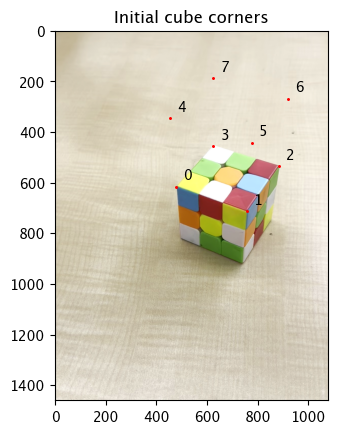

In [64]:
# project the cube corners
P = estimate_camera_matrix(known_points_3D, initial_points_2D)
cube_corners_2D = project_points(cube_corners, P)
# display the cube corners
show_image_with_numbers(first_frame, cube_corners_2D, title='Initial cube corners')

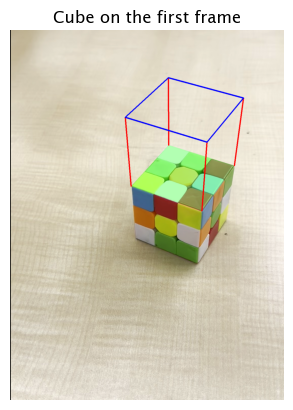

In [65]:
def draw(img, corners, imgpts):
    img = img.copy()
    imgpts = np.int32(imgpts).reshape(-1,2)
    
    # Create a separate image for the floor
    floor = img.copy()
    # Draw floor in green with some transparency
    cv2.drawContours(floor, [imgpts[:4]], -1, (0,255,0), -3)
    # Blend the floor with original image
    alpha = 0.3  # Transparency factor
    img = cv2.addWeighted(floor, alpha, img, 1 - alpha, 0)
    
    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)
    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)
    return img

# draw the cube on the first frame
img = draw(first_frame, corners=None, imgpts=cube_corners_2D)
show_image(img, title='Cube on the first frame')


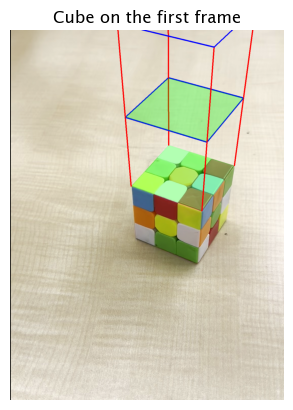

In [66]:
# master function
def draw_cube(frame, origins, P, size=None):
    img = frame.copy()
    for i, origin in enumerate(origins):
        # generate the points for the cube
        cube_points = get_cube_corners(origin, size=size[i])
        # project the points
        cube_points_2D = project_points(cube_points, P)
        # draw the cube on the first frame
        img = draw(img, corners=None, imgpts=cube_points_2D)
    return img

img = draw_cube(first_frame, [np.array([0,0,3]), np.array([0,0,6])], P, size=[3, 3])
show_image(img, title='Cube on the first frame')


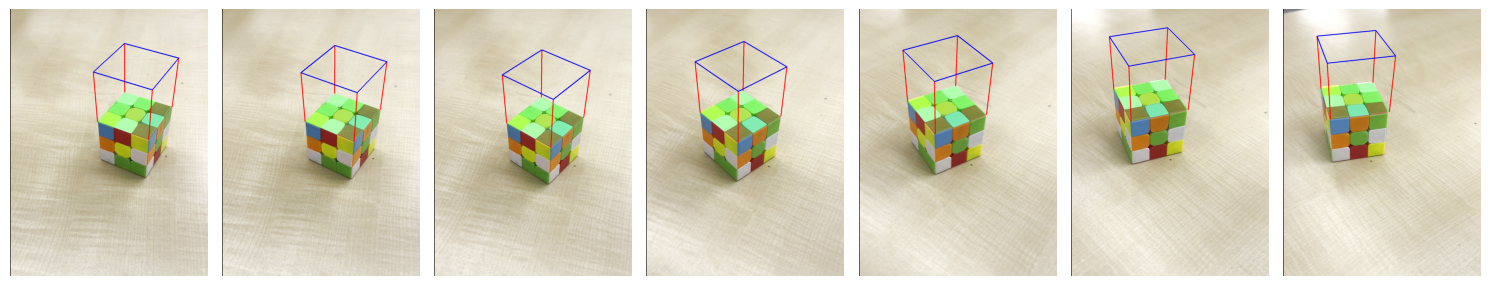

In [67]:
# call the function for each frame
frames_with_cubes = []
for i in range(len(frames)):
    frame = frames[i]
    # get the tracked points
    tracked_points_frame = tracked_points[i]
    # calculate P for each frame
    try:
        P = estimate_camera_matrix(known_points_3D, tracked_points_frame)
    except:
        print(f"Failed to estimate P for frame {i}")
        continue
    # draw the cube on the frame
    img = draw_cube(frame, [np.array([0,0,3])], P, size=[3])
    frames_with_cubes.append(img)

show_collection_of_images(frames_with_cubes[::skip], titles=None, points=None, show_numbers=False, s=10)

# stitching the frames back together into a video

In [68]:
# save frames as video
output_path = os.path.join(OUTPUT_PATH, 'output_video.mp4')
height, width = frames_with_cubes[0].shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 30.0, (width, height))

for frame in frames_with_cubes:
    # Convert RGB to BGR for video writing
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame_bgr)
out.release()
print(f"Video saved to {output_path}")


Video saved to ../../outputs/output_video.mp4


In [69]:
make_video(frames_with_cubes, os.path.join(OUTPUT_PATH, 'morphing_cube.gif'))
# display the gif
display(Image(filename='morphing_cube.gif'))

FileNotFoundError: [Errno 2] No such file or directory: 'morphing_cube.gif'